In [1]:
import pandas as pd

data = pd.read_csv("../data/processed/merged/full_main.tsv", sep="\t")
data.lang_id.value_counts()

tur    1290
nld    1290
vie    1290
ita    1290
ukr    1290
ara    1290
Name: lang_id, dtype: int64

In [2]:
data['lang_id'] = data['lang_id'].map(
    {'ara': 'Arabic', 'ita': 'Italian', 'nld': 'Dutch', 'tur': 'Turkish', 'ukr': 'Ukrainian', 'vie': 'Vietnamese'}
)
data['task_type'] = data['task_type'].map(
    {'ht': 'From Scratch (HT)', 'pe1': 'Google Translate (PE1)', 'pe2': "mBART-50 (PE2)"}
)

In [3]:
def print_outliers(data, field, threshold_value, see_ids=False):
    print("Arabic", len(data[(data.lang_id == "Arabic") & (data.loc[:, field] > threshold_value)]))
    print("Italian", len(data[(data.lang_id == "Italian") & (data.loc[:, field] > threshold_value)]))
    print("Dutch", len(data[(data.lang_id == "Dutch") & (data.loc[:, field] > threshold_value)]))
    print("Turkish", len(data[(data.lang_id == "Turkish") & (data.loc[:, field] > threshold_value)]))
    print("Ukrainian", len(data[(data.lang_id == "Ukrainian") & (data.loc[:, field] > threshold_value)]))
    print("Vietnamese", len(data[(data.lang_id == "Vietnamese") & (data.loc[:, field] > threshold_value)]))
    if see_ids:
        print("Arabic", list(data[(data.lang_id == "Arabic") & (data.loc[:, field] > threshold_value)].item_id))
        print("Italian", list(data[(data.lang_id == "Italian") & (data.loc[:, field] > threshold_value)].item_id))
        print("Dutch", list(data[(data.lang_id == "Dutch") & (data.loc[:, field] > threshold_value)].item_id))
        print("Turkish", list(data[(data.lang_id == "Turkish") & (data.loc[:, field] > threshold_value)].item_id))
        print("Ukrainian", list(data[(data.lang_id == "Ukrainian") & (data.loc[:, field] > threshold_value)].item_id))
        print("Vietnamese", list(data[(data.lang_id == "Vietnamese") & (data.loc[:, field] > threshold_value)].item_id))

print_outliers(data, "time_m", 45, True)

Arabic 2
Italian 0
Dutch 0
Turkish 0
Ukrainian 0
Vietnamese 15
Arabic ['flores101-main-1003', 'flores101-main-541']
Italian []
Dutch []
Turkish []
Ukrainian []
Vietnamese ['flores101-main-1001', 'flores101-main-1021', 'flores101-main-1061', 'flores101-main-1072', 'flores101-main-1074', 'flores101-main-132', 'flores101-main-243', 'flores101-main-284', 'flores101-main-31', 'flores101-main-32', 'flores101-main-331', 'flores101-main-332', 'flores101-main-403', 'flores101-main-503', 'flores101-main-412']


In [4]:
outliers = [
    'flores101-main-1003', 'flores101-main-541', 'flores101-main-1001', 'flores101-main-1021', 'flores101-main-1061', 
    'flores101-main-1072', 'flores101-main-1074', 'flores101-main-132', 'flores101-main-243', 'flores101-main-284', 
    'flores101-main-31', 'flores101-main-32', 'flores101-main-331', 'flores101-main-332', 'flores101-main-403', 'flores101-main-503', 'flores101-main-412'
]
filtered_data = data[~data.item_id.isin(outliers)]
filtered_data.lang_id.value_counts()

Italian       1239
Dutch         1239
Ukrainian     1239
Arabic        1239
Turkish       1239
Vietnamese    1239
Name: lang_id, dtype: int64

In [5]:
# Compute productivity gains with respect to translation from scratch for every sentence
list_ht_prod = filtered_data[filtered_data.task_type == "From Scratch (HT)"][["lang_id", "item_id", "words_per_minute"]].to_dict(orient="records")
dic_ht_prod = {(x["lang_id"], x["item_id"]): x["words_per_minute"] for x in list_ht_prod}
filtered_data["delta_prod"] = filtered_data.apply(lambda x: (x["words_per_minute"] - dic_ht_prod[(x["lang_id"], x["item_id"])]) / abs(dic_ht_prod[(x["lang_id"], x["item_id"])]), axis=1)

/tmp/ipykernel_26691/2626347442.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["delta_prod"] = filtered_data.apply(lambda x: (x["words_per_minute"] - dic_ht_prod[(x["lang_id"], x["item_id"])]) / abs(dic_ht_prod[(x["lang_id"], x["item_id"])]), axis=1)


In [9]:
# Regroup by document
doc_grouped = filtered_data.groupby(["doc_id", "subject_id", "lang_id", "task_type"]).sum()
doc_grouped.reset_index(level=[0,1,2,3], inplace=True)
doc_grouped.words_per_minute = doc_grouped.src_len_wrd / doc_grouped.time_m
doc_grouped.key_per_char = doc_grouped.k_total / doc_grouped.src_len_chr
doc_grouped.time_per_char = doc_grouped.time_s / doc_grouped.src_len_chr
doc_grouped.time_per_word = doc_grouped.time_s / doc_grouped.src_len_wrd

list_ht_prod_doc = filtered_data[filtered_data.task_type == "From Scratch (HT)"].groupby(["lang_id", "doc_id"]).sum().reset_index(level=[0,1])[["lang_id", "doc_id", "src_len_wrd", "time_m"]].to_dict(orient="records")
dic_ht_prod_doc = {(x["lang_id"], x["doc_id"]): x["src_len_wrd"] / x["time_m"] for x in list_ht_prod_doc}
doc_grouped.delta_prod = doc_grouped.apply(lambda x: (x["words_per_minute"] - dic_ht_prod_doc[(x["lang_id"], x["doc_id"])]) / abs(dic_ht_prod_doc[(x["lang_id"], x["doc_id"])]), axis=1)
doc_grouped.bleu = list(filtered_data.groupby(["doc_id", "subject_id", "lang_id", "task_type"]).mean()["bleu"])
doc_grouped.chrf = list(filtered_data.groupby(["doc_id", "subject_id", "lang_id", "task_type"]).mean()["chrf"])
doc_grouped.hter = list(filtered_data.groupby(["doc_id", "subject_id", "lang_id", "task_type"]).mean()["hter"])

# Plotting

In [10]:
import numpy as np
from plotnine import (
    ggplot, aes, geom_boxplot, labs, facet_grid, xlab, ylab, scale_y_continuous,
    ggtitle, scale_fill_brewer, element_blank, element_line, element_text, theme, annotate, scale_fill_manual, facet_wrap
)

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 27 rows containing non-finite values.
findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.


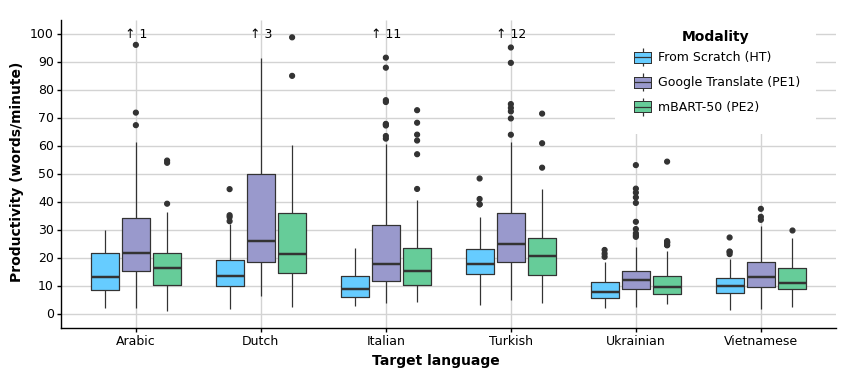

<ggplot: (8728315235572)>

In [11]:
plot = (
    ggplot(
        doc_grouped, aes("lang_id", "words_per_minute", fill="task_type")
    )
    + geom_boxplot()
    + xlab("Target language")
    + ylab("Productivity (words/minute)")
    + scale_y_continuous(breaks=np.arange(0, 105, 10),
        limits=[0, 100])
    + theme(
        legend_position=(0.78, 0.75),
        legend_title=element_text(size=10, face="bold", colour="black"),
        legend_text=element_text(size=9, colour="black"),
        legend_title_align="center",
        legend_box_spacing=0.4,
        legend_key=element_blank(),
        axis_line=element_line(size=1, colour="black"),
        panel_grid_major=element_line(colour="#d3d3d3"),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank(),
        plot_title=element_text(size=15, family="Tahoma", face="bold"),
        text=element_text(family="Tahoma", size=9),
        axis_text_x=element_text(colour="black", size=9),
        axis_text_y=element_text(colour="black", size=9),
        figure_size=(10,4),
        axis_title=element_text(size=10, face="bold", colour="black"),
    )
    + scale_fill_manual(values=["#66CCFF", "#9999CC", "#66CC99"], name="Modality")
    + annotate("text", size=9, color = 'black', x = 1, y = 100, label="↑ 1")
    + annotate("text", size=9, color = 'black', x = 2, y = 100, label="↑ 3")
    + annotate("text", size=9, color = 'black', x = 3, y = 100, label="↑ 11")
    + annotate("text", size=9, color = 'black', x = 4, y = 100, label="↑ 12")
)
plot


In [202]:
from plotnine import save_as_pdf_pages

save_as_pdf_pages([plot], "productivity_per_document.pdf")

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/ggplot.py:820: PlotnineWarning: Filename: productivity_per_document.pdf
/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 27 rows containing non-finite values.


/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 2 rows containing non-finite values.


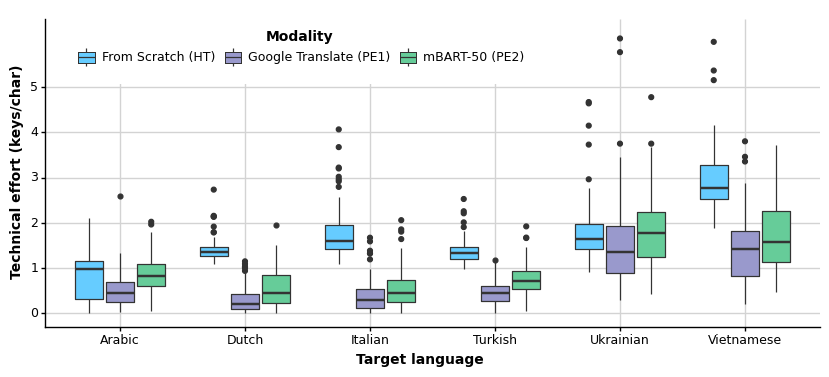

<ggplot: (8728312963344)>

In [12]:
plot = (
    ggplot(
        doc_grouped, aes("lang_id", "key_per_char", fill="task_type")
    )
    + geom_boxplot()
    + xlab("Target language")
    + ylab("Technical effort (keys/char)")
    + scale_y_continuous(breaks=np.arange(0, 6, 1), 
                     limits=[0, 6.2])
    + theme(
        legend_position=(0.38, 0.81),
        legend_direction="horizontal",
        legend_title=element_text(size=10, face="bold", colour="black"),
        legend_text=element_text(size=9, colour="black"),
        legend_title_align="center",
        legend_box_spacing=0.4,
        legend_key=element_blank(),
        axis_line=element_line(size=1, colour="black"),
        panel_grid_major=element_line(colour="#d3d3d3"),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank(),
        plot_title=element_text(size=15, family="Tahoma", face="bold"),
        text=element_text(family="Tahoma", size=9),
        axis_text_x=element_text(colour="black", size=9),
        axis_text_y=element_text(colour="black", size=9),
        axis_title=element_text(size=10, face="bold", colour="black"),
        figure_size=(10,4)
    )
    + scale_fill_manual(values=["#66CCFF", "#9999CC", "#66CC99"], name="Modality")
)
plot

In [205]:
from plotnine import save_as_pdf_pages

save_as_pdf_pages([plot], "technical_effort.pdf")

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/ggplot.py:820: PlotnineWarning: Filename: technical_effort.pdf
/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 2 rows containing non-finite values.


/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 24 rows containing non-finite values.


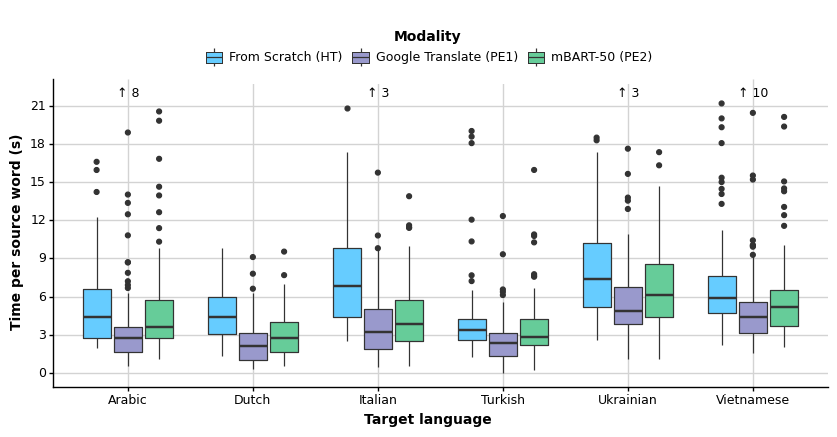

<ggplot: (8728379243807)>

In [13]:
import numpy as np
from plotnine import (
    ggplot, aes, geom_boxplot, labs, facet_grid, xlab, ylab, scale_y_continuous,
    ggtitle, scale_fill_brewer, element_blank, element_line, element_text, theme, annotate, scale_fill_manual
)

plot = (
    ggplot(# time_per_word
        doc_grouped, aes("lang_id", "time_per_word", fill="task_type")
    )
    + geom_boxplot()
    + xlab("Target language")
    + ylab("Time per source word (s)")
    + scale_y_continuous(breaks=np.arange(0, 22, 3),
        limits=[0, 22])
    + theme(
        legend_position=(0.5, 0.96),
        legend_title=element_text(size=10, face="bold", colour="black"),
        legend_text=element_text(size=9, colour="black"),
        legend_title_align="center",
        legend_direction="horizontal",
        legend_box_spacing=0.4,
        legend_key=element_blank(),
        axis_line=element_line(size=1, colour="black"),
        panel_grid_major=element_line(colour="#d3d3d3"),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank(),
        plot_title=element_text(size=15, family="Tahoma", face="bold"),
        text=element_text(family="Tahoma", size=9),
        axis_text_x=element_text(colour="black", size=9),
        axis_text_y=element_text(colour="black", size=9),
        figure_size=(10,4),
        axis_title=element_text(size=10, face="bold", colour="black"),
    )
    + scale_fill_manual(values=["#66CCFF", "#9999CC", "#66CC99"], name="Modality")
    + annotate("text", size=9, color = 'black', x = 1, y = 22, label="↑ 8")
    + annotate("text", size=9, color = 'black', x = 3, y = 22, label="↑ 3")
    + annotate("text", size=9, color = 'black', x = 5, y = 22, label="↑ 3")
    + annotate("text", size=9, color = 'black', x = 6, y = 22, label="↑ 10")
)
plot

In [14]:
print_outliers(doc_grouped, "time_per_word", 22)

Arabic 8
Italian 0
Dutch 3
Turkish 0
Ukrainian 3
Vietnamese 10


In [62]:
from plotnine import save_as_pdf_pages

save_as_pdf_pages([plot], "time_per_src_word.pdf")

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/ggplot.py:820: PlotnineWarning: Filename: time_per_src_word.pdf
/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 24 rows containing non-finite values.


In [15]:
full_groups = filtered_data[["subject_id", "task_type"]]
full_groups = full_groups[full_groups["task_type"] != "ht"]
filter_groups = filtered_data[filtered_data.tot_edits < 1][["subject_id", "task_type"]]
filter_groups = filter_groups[filter_groups["task_type"] != "ht"]
x = filter_groups.value_counts() / full_groups.value_counts()
x.fillna(0).to_csv("../outputs/out_edits_eval.csv")
x = pd.read_csv("../outputs/out_edits_eval.csv")
x["lang"] = x.subject_id.str.split("_").map(lambda x: x[0])
x['lang'] = x['lang'].map(
    {'ara': 'Arabic', 'ita': 'Italian', 'nld': 'Dutch', 'tur': 'Turkish', 'ukr': 'Ukrain.', 'vie': 'Vietnam.'}
)
x["subject_id"] = x.subject_id.str.split("_").map(lambda x: x[1])
x.rename({"0": "score"}, axis=1, inplace=True)
x.loc[x[(x.lang == "Italian") & (x.subject_id == "t5")].index, "subject_id"] = "t2"
x.loc[x[(x.lang == "Italian") & (x.subject_id == "t4")].index, "subject_id"] = "t3"
x["score"] = x["score"] * 100

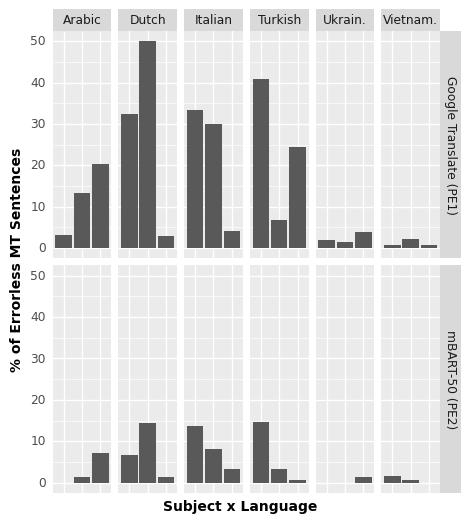

<ggplot: (8728315254405)>

In [16]:
from plotnine import geom_col, facet_grid

plot = (
    ggplot(
        x[x.task_type != "From Scratch (HT)"], aes("subject_id", "score")
    )
    + geom_col()
    + facet_grid("task_type ~ lang")
    + xlab("Subject x Language")
    + ylab("% of Errorless MT Sentences")
    + theme(
        axis_title=element_text(size=10, face="bold", colour="black"),
        axis_text_x=element_blank(),
        axis_ticks=element_blank(),
        figure_size=(5,6)
    )
    + scale_fill_brewer(type="qual", palette="Accent", name="Translation setting")
)
plot

In [60]:
from plotnine import save_as_pdf_pages

save_as_pdf_pages([plot], "errorless_outputs.pdf")

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/ggplot.py:820: PlotnineWarning: Filename: errorless_outputs.pdf


/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 5 rows containing non-finite values.
findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.


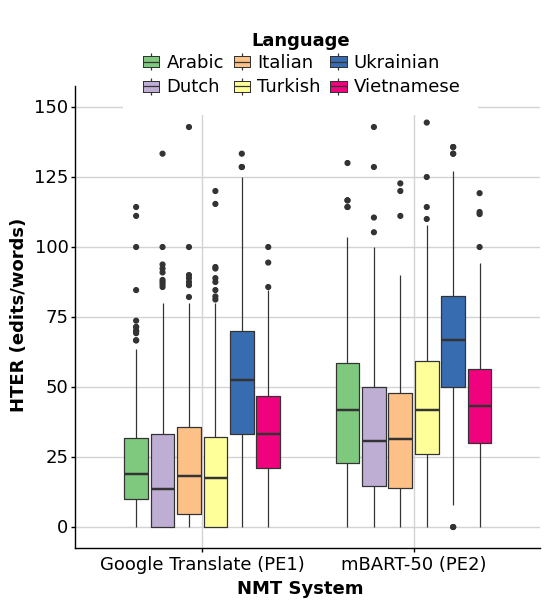

<ggplot: (8728312453337)>

In [17]:
plot = (
    ggplot(
        filtered_data[filtered_data.task_type.isin(["Google Translate (PE1)", "mBART-50 (PE2)"])], aes("task_type", "hter", fill="lang_id")
    )
    + geom_boxplot()
    + xlab("NMT System")
    + ylab("HTER (edits/words)")
    + scale_y_continuous(limits=[0, 150], breaks=np.arange(0, 155, 25))
    + theme(
        legend_position=(0.50, 0.92),
        legend_direction="horizontal",
        legend_title_align="center",
        legend_box_spacing=0.4,
        legend_key=element_blank(),
        axis_line=element_line(size=1, colour="black"),
        panel_grid_major=element_line(colour="#d3d3d3"),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank(),
        plot_title=element_text(size=15, family="Tahoma", face="bold"),
        text=element_text(family="Tahoma", size=13),
        axis_text_x=element_text(colour="black", size=13),
        axis_text_y=element_text(colour="black", size=13),
        figure_size=(6,6),
        axis_title=element_text(size=13, face="bold", colour="black"),
        legend_title=element_text(size=13, face="bold", colour="black"),
    )
    + scale_fill_brewer(type="qual", palette="Accent", name="Language")
)
plot

In [28]:
from plotnine import save_as_pdf_pages

save_as_pdf_pages([plot], "../outputs/hter_per_system.pdf")

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/ggplot.py:820: PlotnineWarning: Filename: ../outputs/hter_per_system.pdf
/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 5 rows containing non-finite values.
findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.


In [18]:
doc_grouped[["lang_id", "subject_single_id"]] = doc_grouped.subject_id.str.split("_", expand=True)
doc_grouped['lang_id'] = doc_grouped['lang_id'].map({'ara': 'Arabic', 'ita': 'Italian', 'nld': 'Dutch', 'tur': 'Turkish', 'ukr': 'Ukrainian', 'vie': 'Vietnamese'})
doc_grouped.subject_single_id.replace({'t4': 't3', 't5': 't2'}, inplace=True)
doc_grouped.subject_single_id.replace({'t1': 'Subject 1', 't2': 'Subject 2', 't3': 'Subject 3'}, inplace=True)

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 24 rows containing non-finite values.


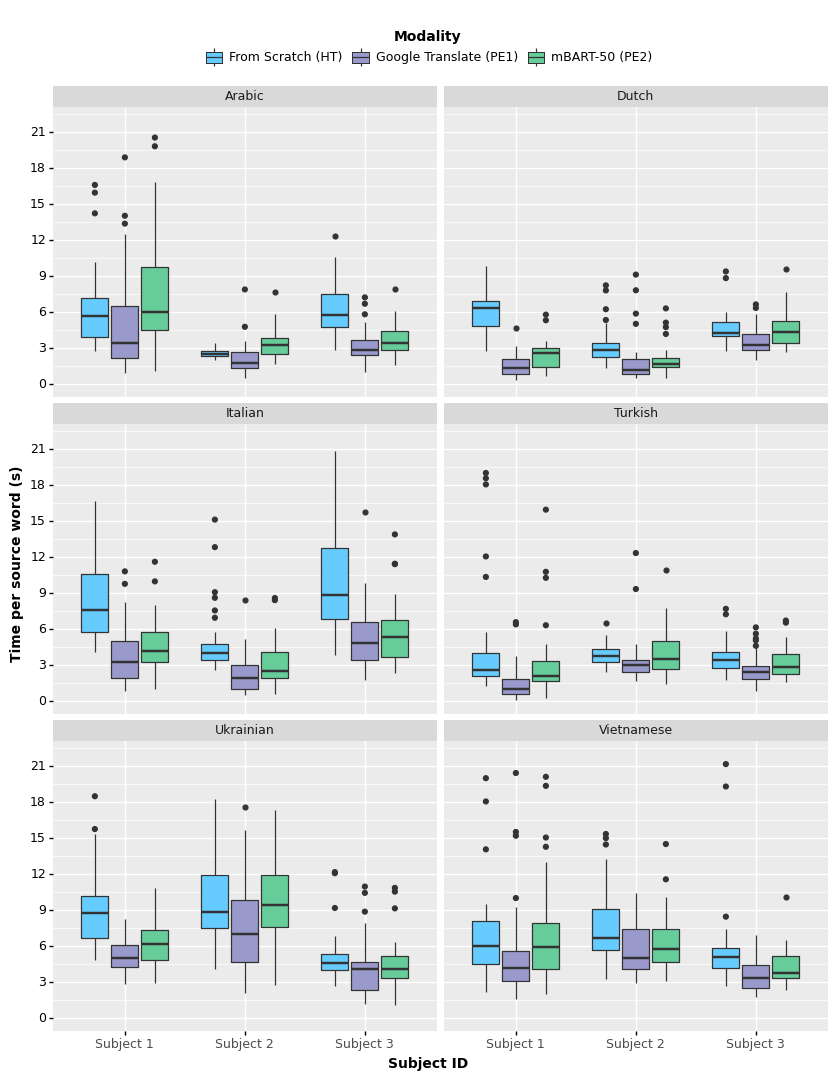

<ggplot: (8728312338755)>

In [19]:
plot = (
    ggplot(
        doc_grouped, aes("subject_single_id", "time_per_word", fill="task_type")
    )
    + geom_boxplot()
    + scale_fill_manual(values=["#66CCFF", "#9999CC", "#66CC99"], name="Modality")
    + facet_wrap("~ lang_id", nrow=3)
    + ylab("Time per source word (s)")
    + xlab("Subject ID")
    + scale_y_continuous(breaks=np.arange(0, 22, 3), 
                     limits=[0, 22])
    + theme(
        legend_position=(0.50, 0.93),
        legend_direction="horizontal",
        legend_title_align="center",
        legend_box_spacing=0.4,
        legend_title=element_text(size=10, face="bold", colour="black"),
        legend_key=element_blank(),
        text=element_text(family="Tahoma", size=9),
        axis_text_y=element_text(colour="black", size=9),
        figure_size=(10,12),
        axis_title=element_text(size=10, face="bold", colour="black"),
    )
)
plot

In [90]:
from plotnine import save_as_pdf_pages

save_as_pdf_pages([plot], "../outputs/trans_time_per_word_per_mode.pdf")

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/ggplot.py:820: PlotnineWarning: Filename: ../outputs/trans_time_per_word_per_mode.pdf
/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 24 rows containing non-finite values.


# Scores and Correlations

In [20]:
lang_grouped_median = doc_grouped.groupby(["lang_id", "task_type"]).median()
lang_grouped_median.reset_index(level=[0,1], inplace=True)
lang_grouped_median[["lang_id", "task_type", "words_per_minute", "delta_prod", "hter"]]

,lang_id,task_type,words_per_minute,delta_prod,hter
0,Arabic,From Scratch (HT),13.125376,0.000000,NaN
1,Arabic,Google Translate (PE1),21.726673,0.841105,19.485400
2,Arabic,mBART-50 (PE2),16.287586,0.097658,41.387667
3,Dutch,From Scratch (HT),13.621550,0.000000,NaN
4,Dutch,Google Translate (PE1),28.704447,1.185477,14.285667
5,Dutch,mBART-50 (PE2),21.708249,0.606589,32.422750
6,Italian,From Scratch (HT),8.760813,0.000000,NaN
7,Italian,Google Translate (PE1),18.600289,0.962913,19.192000
8,Italian,mBART-50 (PE2),15.619779,0.949084,31.052750
9,Turkish,From Scratch (HT),17.944462,0.000000,NaN


In [21]:
lang_grouped_mean = doc_grouped.groupby(["lang_id", "task_type"]).mean()
lang_grouped_mean.reset_index(level=[0,1], inplace=True)
lang_grouped_mean[["lang_id", "task_type", "words_per_minute", "delta_prod", "hter"]]

,lang_id,task_type,words_per_minute,delta_prod,hter
0,Arabic,From Scratch (HT),15.140944,0.000000,NaN
1,Arabic,Google Translate (PE1),26.685869,1.490138,22.781066
2,Arabic,mBART-50 (PE2),16.952308,0.463584,41.996365
3,Dutch,From Scratch (HT),15.332657,0.000000,NaN
4,Dutch,Google Translate (PE1),44.861575,3.808754,20.776179
5,Dutch,mBART-50 (PE2),27.256527,1.325363,34.399926
6,Italian,From Scratch (HT),9.946033,0.000000,NaN
7,Italian,Google Translate (PE1),26.552826,2.614879,22.472132
8,Italian,mBART-50 (PE2),19.867604,1.513266,32.817708
9,Turkish,From Scratch (HT),19.324286,0.000000,NaN


In [22]:
lang_grouped_only_lang_mean = doc_grouped.groupby(["lang_id"]).mean()
lang_grouped_only_lang_mean.reset_index(level=[0], inplace=True)
lang_grouped_only_lang_mean[["lang_id", "hter"]]

,lang_id,hter
0,Arabic,32.388716
1,Dutch,27.588052
2,Italian,27.644920
3,Turkish,33.119641
4,Ukrainian,58.961338
5,Vietnamese,39.531362


In [23]:
df_google = pd.DataFrame({
    "bleu": [34.1, 29.1, 32.8, 35, 31.1, 45.1],
    "chrf": [65.6, 60, 61.4, 65.5, 59.8, 61.9],
    "ter": [52.8, 58.5, 53.6, 50.4, 55.9, 41.8],
    "comet": [0.737, 0.667, 0.781, 1.000, 0.758, 0.724],
    "prod": [26.685, 44.86, 26.55, 64.66, 14.16, 14.86],
    "delta_prod": [1.49, 3.80, 2.61, 3.16, 0.97, 0.98],
    "hter": [22.78, 20.78, 22.47, 21.67, 51.39, 35.14]
})
df_google.corr()

,bleu,chrf,ter,comet,prod,delta_prod,hter
bleu,1.000000,0.254851,-0.992012,0.067340,-0.298409,-0.517914,0.127038
chrf,0.254851,1.000000,-0.328335,0.601047,0.449949,0.016493,-0.491775
ter,-0.992012,-0.328335,1.000000,-0.189357,0.219336,0.481177,-0.092242
comet,0.067340,0.601047,-0.189357,1.000000,0.649162,0.226509,-0.179088
prod,-0.298409,0.449949,0.219336,0.649162,1.000000,0.825964,-0.657686
delta_prod,-0.517914,0.016493,0.481177,0.226509,0.825964,1.000000,-0.734373
hter,0.127038,-0.491775,-0.092242,-0.179088,-0.657686,-0.734373,1.000000


In [24]:
df_mbart = pd.DataFrame({
    "bleu": [17, 22.6, 24.4, 18.8, 21.9, 34.7],
    "chrf": [48.5, 53.9, 54.7, 52.7, 50.7, 54],
    "ter": [69.1, 63.7, 61.2, 67.5, 67.9, 50.7],
    "comet": [0.452, 0.532, 0.648, 0.755, 0.587, 0.608],
    "prod": [16.95, 27.26, 19.87, 25.96, 11.47, 12.56],
    "delta_prod": [0.46, 1.33, 1.51, 0.60, 0.56, 0.53],
    "hter": [42, 34.40, 32.82, 44.57, 66.53, 43.93]
})
df_mbart.corr()

,bleu,chrf,ter,comet,prod,delta_prod,hter
bleu,1.000000,0.612593,-0.974188,0.138430,-0.417451,0.050335,-0.074185
chrf,0.612593,1.000000,-0.656037,0.544794,0.342025,0.668030,-0.491327
ter,-0.974188,-0.656037,1.000000,-0.140016,0.286952,-0.113750,0.277238
comet,0.138430,0.544794,-0.140016,1.000000,0.266192,0.079479,0.033419
prod,-0.417451,0.342025,0.286952,0.266192,1.000000,0.512679,-0.624904
delta_prod,0.050335,0.668030,-0.113750,0.079479,0.512679,1.000000,-0.640778
hter,-0.074185,-0.491327,0.277238,0.033419,-0.624904,-0.640778,1.000000
